## 점진적인 학습이란
##### - 훈련에 필요한 데이터가 한번에 다 수집된 경우가 아니라
##### - 시간 차를 두고 수집이 되는 경우에는 훈련모델 학습은 언제 해야 할까?
##### - 이런 문제를 해결하기 위해 수집될 때마다 학습을 계속 이어나가는 훈련 방식을
##### - "점진적인 학습"이라고 함
##### --> "점진적인 학습" 또는 온라인 학습이라 칭함
##### - 대표적인 점진적 학습 알고리즘은 "확률적경사하강법"

## 확률적 경사 하강법(SGD ; Stochastic Gradient Descent)
##### - 경사 : 우리가 흔히 사용하는 단어인 경사(기울기)
##### - 하강법 : 내려가는 방법
##### - 경사 하강법?
#####    : 원하는 지점에 도착하기 위해 가장 가파른 경사를 따라 내려가는 방법을 찾는 방법
##### - 확률적 : "무작위하게" 또는 "랜덤하게"의 기술적 표현 언어
#####   : 훈련데이터의 전체 특성들 중에서 하나씩 랜덤하게 선택하여 가장 가파른 길 찾음
### < 확률적 경사 하강법 순서>


#### 데이터 불러오기

In [4]:
import pandas as pd
fish = pd.read_csv('./data/07_fish.csv')
fish.head(10)

,Species,Weight,Length,Diagonal,Height,Width
0,Bream,242.0,25.4,30.0,11.5200,4.0200
1,Bream,290.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,26.5,31.1,12.3778,4.6961
3,Bream,363.0,29.0,33.5,12.7300,4.4555
4,Bream,430.0,29.0,34.0,12.4440,5.1340
5,Bream,450.0,29.7,34.7,13.6024,4.9274
6,Bream,500.0,29.7,34.5,14.1795,5.2785
7,Bream,390.0,30.0,35.0,12.6700,4.6900
8,Bream,450.0,30.0,35.1,14.0049,4.8438
9,Bream,500.0,30.7,36.2,14.2266,4.9594


In [8]:
fish.describe()
fish.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Species   159 non-null    object 
 1   Weight    159 non-null    float64
 2   Length    159 non-null    float64
 3   Diagonal  159 non-null    float64
 4   Height    159 non-null    float64
 5   Width     159 non-null    float64
dtypes: float64(5), object(1)
memory usage: 7.6+ KB


#### 2. 데이터 전처리

In [16]:
### 독립변수와 종속변수 분리하여 변수화
# 독립변수명 : fish_input
# 종속변수명 : fish_target

fish_input = fish[['Weight','Length','Diagonal','Height','Width']].to_numpy()
fish_input[:10]

fish_target = fish['Species'].to_numpy()
fish_target[:5]

array(['Bream', 'Bream', 'Bream', 'Bream', 'Bream'], dtype=object)

In [22]:
### 훈련(입력, 타겟) / 테스트(입력, 타켓) 데이터 분류
from sklearn.model_selection import train_test_split

train_input, test_input, train_target, test_target = train_test_split(fish_input, fish_target,
                                                                      test_size = 0.25,random_state = 42)

print(train_input.shape)
print(train_target.shape)
print(test_input.shape)
print(test_target.shape)

(119, 5)
(119,)
(40, 5)
(40,)


In [23]:
### 정규화(표준화) -> 독립변수 표준점수로 동일하게 표준화(스케일)
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

ss.fit(train_input)

train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

print(ss.mean_, ss.scale_)
print("-----------------------")
print(train_scaled[ :5])
print("-----------------------")
print(test_scaled[ :5])

[393.27226891  28.49663866  31.2697479    8.86248403   4.44828655] [355.27097574  10.67118899  11.5129708    4.04941829   1.64047206]
-----------------------
[[ 0.91965782  0.60943175  0.81041221  1.85194896  1.00075672]
 [ 0.30041219  1.54653445  1.45316551 -0.46981663  0.27291745]
 [-1.0858536  -1.68646987 -1.70848587 -1.70159849 -2.0044758 ]
 [-0.79734143 -0.60880176 -0.67486907 -0.82480589 -0.27631471]
 [-0.71289885 -0.73062511 -0.70092664 -0.0802298  -0.7033869 ]]
-----------------------
[[-0.88741352 -0.91804565 -1.03098914 -0.90464451 -0.80762518]
 [-1.06924656 -1.50842035 -1.54345461 -1.58849582 -1.93803151]
 [-0.54401367  0.35641402  0.30663259 -0.8135697  -0.65388895]
 [-0.34698097 -0.23396068 -0.22320459 -0.11905019 -0.12233464]
 [-0.68475132 -0.51509149 -0.58801052 -0.8998784  -0.50124996]]


### 확률적 경사 하강법을 이용한 분류

In [37]:
### 객체(모델) 생성하기
# - loss : 손실함수 (log=로지스틱 손실함수 사용)
#        : 조금씩 내려오면서 손실이 작은쪽을 찾아서 내려오기 위한 방법
#        : 사람은 손실이 작은 값들을 알 수 없습니다.
#          (학습모델이 가지고 있는 손실 계산식을 통해 결정합니다.)
#        : 분류 결과에 만족한다면, 다 내려왔다고 인정해야 함
#        : 사람이 직접 만들거나 직접 계산하지는 않음(관여하지 않음)
#        : 훈련모델이 직접 수행
#        : 사람은 분류 성격에 맞게 사용할 손실함수를 지정만 합니다.
# - max_iter : 훈련 반복 횟수 
#            (전체 특성이 다 끝나면 1회로 본다 -> 이를 "에포크"라 함)
#        : 훈련 반복 회수가 부족한 경우 다 내려오기 전에 끝..?
#        : 분류 정확도가 낮아질수도(과소적합), 높아질수도(과대적합)
#        : 가장 적합한 반복 시점(에포크)을 찾아야 함..
#          (에포크는 사람이 찾아서 max_iter에 넣어 줄 수 있음)

In [41]:
### 사용 클래스(모델) : SGDClassifier

from sklearn.linear_model import SGDClassifier

# 클래스(모델) 생성
sc = SGDClassifier(loss='log',max_iter=10, random_state=42)
sc.fit(train_scaled, train_target)
print(sc.score(train_scaled, train_target))
print(sc.score(test_scaled, test_target))

###(해석)
# - 훈련모델의 학습능력이 다소 떨어짐
# - 이는 훈련 및 테스트 모두 과소적합을 보인다고 할 수 있음

0.773109243697479
0.775


C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


In [35]:
### 점진적 학습 시작
# 새로운 데이터가 들어왔다고 가정(실제로는 새로운 데이터 사용)
sc.partial_fit(train_scaled, train_target)

print(sc.score(train_scaled, train_target))
print(sc.score(test_scaled, test_target))

0.8151260504201681
0.85


C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


### 에포크 반복횟수 찾기

In [ ]:
import numpy as np

sc = SGDClassifier(loss = 'log', random_state=42)

train_score = []
test_score = []

# 범주 고유값
classes = np.unique(train_target)

# 반복을 300회 이상으로 테스트하여 정확도를 리스트에 저장
for _ in range(0, 300):
    sc.partial_fit(train_scaled,  train_target, classes = classes)
    
    train_score.append(sc.score(train_scaled, train_target))
    test_score.append(sc.score(test_scaled, test_target))

In [39]:
print("훈련 정확도 리스트 갯수 =", len(train_score))
print("테스트 정확도 리스트 갯수 =", len(test_score))

훈련 정확도 리스트 갯수 = 300
테스트 정확도 리스트 갯수 = 300


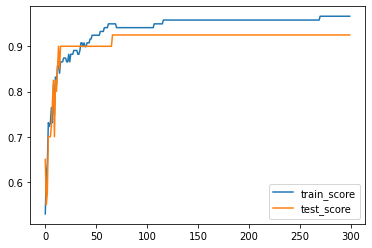

In [44]:
### 최적의 에포크 위치확인하기 : 시각화
import matplotlib.pyplot as plt

plt.plot(train_score, label='train_score')
plt.plot(test_score, label='test_score')
plt.legend()
plt.show()

In [50]:
### 최적의 에포크값 이용해 처음부터 훈련 시작
### 사용 클래스(모델) : SGDClassifier

from sklearn.linear_model import SGDClassifier

# 클래스(모델) 생성
# tol = None : 스스로 훈련이 끝나도 멈추지 말고 지정값까지 돌게 함
sc = SGDClassifier(loss='log',max_iter=100, tol=None, random_state=42)
sc.fit(train_scaled, train_target)
print(sc.score(train_scaled, train_target))
print(sc.score(test_scaled, test_target))



0.957983193277311
0.925


C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


### 모델 예측값 데이터프레임에 저장

In [ ]:
##### [문제]
##### - 새로운 데이터가 수집되었다고 가정하고 예측을 통해 결과값 저장
# - 기존 fish 데이터 전체를 신규데이터라고 가정하고 진행
# - 신규 데이터는 weight, length, diagonal, height, width
#   ( 데이터프레임 변수는 별도로 만들어서 사용)

##### - 데이터프레임에 예측결과에 대한 species_pred 컬럼 추가

##### <출력 결과>
# - Species_pred가 추가된 데이터프레임 출력
#   (출력결과) 데이터프레임의 7개 컬럼 모두 출력
#   weight, length, diagonal, height, width, species, species_pred

# - 정답률 맞춘 갯수와 틀린 갯수 출력
#   (출력 예시) 총 갯수[159]건 중, 정답 [149]건, 오답[10]건

# - 정답률 오답률 출력
#   (출력 예시) 총 100.0% 중 정답률[93.7%], 오답률[6.29%]

In [65]:
predict_data = fish[['Weight','Length','Diagonal','Height','Width']].to_numpy()

In [66]:
predict_scaled = ss.transform(predict_data)

In [70]:
### 예측을 통해 "class_pred" 컬럼 신규 생성하여 
# 예측 데이터 결과 확인하기
result_predict = sc.predict(predict_scaled)

fish_pred = fish[['Weight','Length','Diagonal','Height','Width']]
fish_pred["Species"] = fish["Species"]
fish_pred["Species_pred"] = result_predict
fish_pred

,Weight,Length,Diagonal,Height,Width,Species,Species_pred
0,242.0,25.4,30.0,11.5200,4.0200,Bream,Bream
1,290.0,26.3,31.2,12.4800,4.3056,Bream,Bream
2,340.0,26.5,31.1,12.3778,4.6961,Bream,Bream
3,363.0,29.0,33.5,12.7300,4.4555,Bream,Bream
4,430.0,29.0,34.0,12.4440,5.1340,Bream,Bream
...,...,...,...,...,...,...,...
154,12.2,12.2,13.4,2.0904,1.3936,Smelt,Smelt
155,13.4,12.4,13.5,2.4300,1.2690,Smelt,Smelt
156,12.2,13.0,13.8,2.2770,1.2558,Smelt,Smelt
157,19.7,14.3,15.2,2.8728,2.0672,Smelt,Smelt


In [71]:
### 정답 갯수와 오답 갯수 확인하기
o_cnt = len(fish_pred[(fish_pred["Species"] == fish_pred["Species_pred"])])
o_cnt

x_cnt = len(fish_pred[(fish_pred["Species"] != fish_pred["Species_pred"])])
x_cnt

sum_cnt = len(fish_pred)
sum_cnt 

print("총 갯수[{}]건 중에, 정답갯수[{}]건, 오답 갯수[{}]건".format(sum_cnt, o_cnt, x_cnt))

총 갯수[159]건 중에, 정답갯수[149]건, 오답 갯수[10]건


In [72]:
### 정답률과 오답률 확인하기
import numpy as np

o_p = np.round(o_cnt / sum_cnt * 100, 2)
x_p = np.round(x_cnt / sum_cnt * 100, 2)
sum_p = o_p + x_p

print("총 {}% 중 정답률[{}%], 오답률[{}%]".format(sum_p, o_p, x_p))

총 100.0% 중 정답률[93.71%], 오답률[6.29%]
